In [1]:
#imports
import torch
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue as prologue


In [2]:
#import data for a 1000 pairs
N = 1000
(train_input, train_target, train_classes, 
 test_input, test_target, test_classes) = prologue.generate_pair_sets(N)

#change classes to float type
#train_classes = train_classes.type(torch.float32)
#test_classes = test_classes.type(torch.float32)

#normalize images
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std);


/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor(3.0939)
tensor([5, 4])
tensor(0)


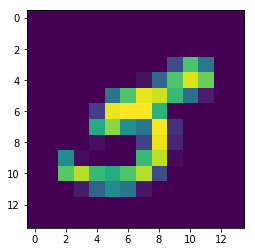

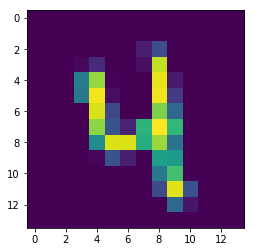

In [3]:
#tests to see what kind of data is there
plt.figure(1)
plt.imshow(train_input[1][0])
print(torch.max(train_input[1][0]))
plt.figure(2)
plt.imshow(train_input[1][1])
print(train_classes[1])
print(train_target[1])

In [9]:
#model, simple cnn with 2 conv layers and one hidden and output layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.fc1(x.view(-1, 64*4*4)))
        x = F.log_softmax(self.fc2(x),dim=1)
        return x

In [13]:
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.1)
    eta = 0.1
    
    for e in range(0, 25):
        sum_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size).view(-1))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            optimizer.step()
        print(e, sum_loss)

In [6]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        for k in range(mini_batch_size):
            #print(target[b + k].type(torch.int64), predicted_classes[k])
            if target[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

In [7]:
#create torch variables
x_train_1, y_train_1 = Variable(train_input.narrow(1,0,1)), Variable(train_classes.narrow(1,0,1))
x_test_1, y_test_1 = Variable(test_input.narrow(1,0,1)), Variable(test_classes.narrow(1,0,1))

#upsample the images because they are too small
x_train_1 =F.upsample(x_train_1,(28,28), mode='bilinear')
x_test_1 =F.upsample(x_test_1,(28,28), mode='bilinear')

#rearrange shape of target data
#y_train_1 = y_train_1.view(N,1)
#y_test_1 = y_test_1.view(N,1)
mini_batch_size = 100


/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hannes/anaconda3/envs/dl2019/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
for k in range(10):
    model = Net()
    train_model(model, x_train_1, y_train_1, mini_batch_size)
    nb_test_errors = compute_nb_errors(model, x_test_1, y_test_1, mini_batch_size)
    print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / x_test_1.size(0),nb_test_errors, 
                                                     x_test_1.size(0)))

0 21.932377338409424
1 16.0148366689682
2 9.653971195220947
3 7.031804174184799
4 4.185783088207245
5 3.5862839818000793
6 2.801062136888504
7 2.3457628339529037
8 2.2036414742469788
9 1.730422392487526
10 1.5021394938230515
11 1.303483985364437
12 1.1386362239718437
13 0.9966531805694103
14 0.8870530091226101
15 0.7914328388869762
16 0.6675752587616444
17 0.5512121822685003
18 0.4540532138198614
19 0.38602199871093035
20 0.33645014744251966
21 0.29303320311009884
22 0.2524577220901847
23 0.22074802312999964
24 0.1906695244833827
test error Net 6.60% 66/1000
0 21.78492546081543
1 16.57758629322052
2 11.692449569702148
3 6.584592580795288
4 4.981584548950195
5 4.026504695415497
6 2.8748272955417633
7 2.529670223593712
8 2.10813669860363
9 1.7558609992265701
10 1.5313896238803864
11 1.3306614384055138
12 1.130324773490429
13 1.011808030307293
14 0.8605330996215343
15 0.7466878145933151
16 0.6111444346606731
17 0.5333576872944832
18 0.46786530688405037
19 0.3934764228761196
20 0.309934297

Target: 6    Model output: 6
Target: 3    Model output: 3
Target: 2    Model output: 2
Target: 5    Model output: 5
Target: 6    Model output: 6


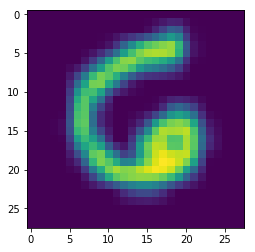

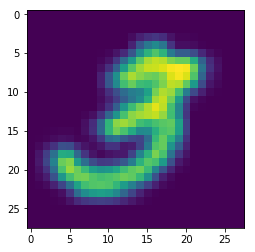

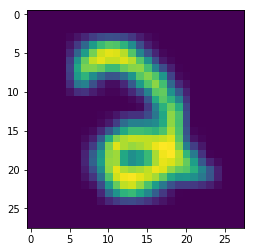

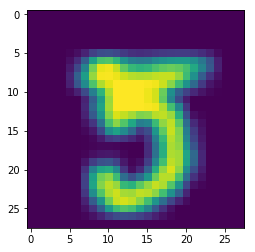

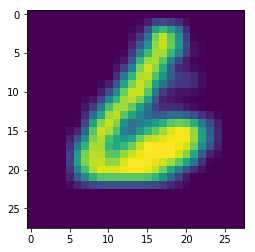

In [23]:
#Quick visualization for model performance 

test_data = x_test_1.narrow(0,900,5)
test_target = y_test_1.narrow(0,900,5)

for b in range(0, test_data.size(0), 5):
        output = model(test_data.narrow(0, b, 5))
        _, predicted_classes = output.data.max(1)
for i in range(0,5):
    plt.figure(i)
    plt.imshow(test_data[i][0])
    print('Target: %d    Model output: %d' %(test_target[i].data,predicted_classes[i].data))
    